In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.classes
num_classes = len(classes)

Files already downloaded and verified
Files already downloaded and verified


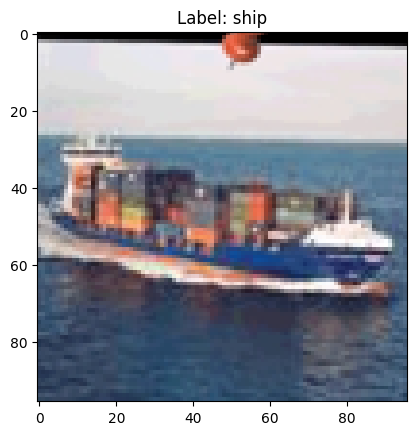

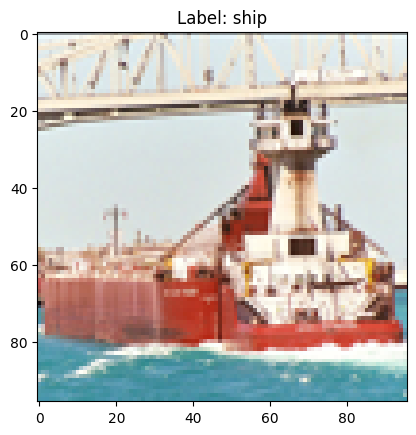

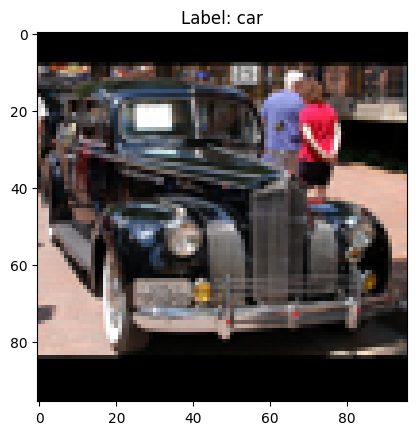

In [3]:
import random

def imshow(img, label):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Label: {label}")
    plt.show()

for _ in range(3):
    idx = random.randint(0, len(train_dataset) - 1)
    image, label = train_dataset[idx]
    imshow(image, classes[label])

In [4]:
class DeFixMatchSTLModel(nn.Module):
    def __init__(self, num_classes):
        super(DeFixMatchSTLModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((6, 6))
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = DeFixMatchSTLModel(num_classes).to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'STL_ReFix.pt')

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20)

Epoch 1/20, Train Loss: 1.7899, Val Loss: 1.5311
Epoch 2/20, Train Loss: 1.4290, Val Loss: 1.3962
Epoch 3/20, Train Loss: 1.2511, Val Loss: 1.4020
Epoch 4/20, Train Loss: 1.1140, Val Loss: 1.2414
Epoch 5/20, Train Loss: 0.9490, Val Loss: 1.1680
Epoch 6/20, Train Loss: 0.8037, Val Loss: 1.2085
Epoch 7/20, Train Loss: 0.6531, Val Loss: 1.4233
Epoch 8/20, Train Loss: 0.5549, Val Loss: 1.2999
Epoch 9/20, Train Loss: 0.3699, Val Loss: 1.4926
Epoch 10/20, Train Loss: 0.2533, Val Loss: 1.6844
Epoch 11/20, Train Loss: 0.1958, Val Loss: 2.0394
Epoch 12/20, Train Loss: 0.1399, Val Loss: 2.1242
Epoch 13/20, Train Loss: 0.1036, Val Loss: 2.0299
Epoch 14/20, Train Loss: 0.0646, Val Loss: 2.2788
Epoch 15/20, Train Loss: 0.0430, Val Loss: 2.2663
Epoch 16/20, Train Loss: 0.0368, Val Loss: 2.3862
Epoch 17/20, Train Loss: 0.0685, Val Loss: 2.3608
Epoch 18/20, Train Loss: 0.1199, Val Loss: 2.2711
Epoch 19/20, Train Loss: 0.0481, Val Loss: 2.5376
Epoch 20/20, Train Loss: 0.0278, Val Loss: 2.5834


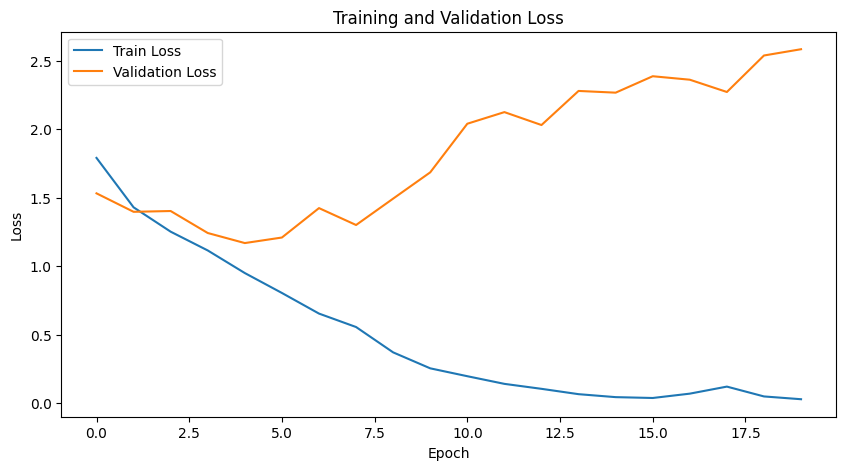

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [8]:
model.load_state_dict(torch.load('STL_ReFix.pt'))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")
print(classification_report(y_true, y_pred, target_names=classes))

C:\Users\dhawal bansal\AppData\Local\Temp\ipykernel_5348\1582398584.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('STL_ReFix.pt'))


Accuracy: 0.5880, Precision: 0.5908, Recall: 0.5880, F1-score: 0.5870

              precision    recall  f1-score   support

    airplane       0.72      0.83      0.77       800
        bird       0.51      0.56      0.54       800
         car       0.71      0.76      0.73       800
         cat       0.44      0.44      0.44       800
        deer       0.51      0.57      0.53       800
         dog       0.41      0.34      0.37       800
       horse       0.68      0.59      0.63       800
      monkey       0.48      0.54      0.51       800
        ship       0.80      0.66      0.72       800
       truck       0.66      0.59      0.62       800

    accuracy                           0.59      8000
   macro avg       0.59      0.59      0.59      8000
weighted avg       0.59      0.59      0.59      8000



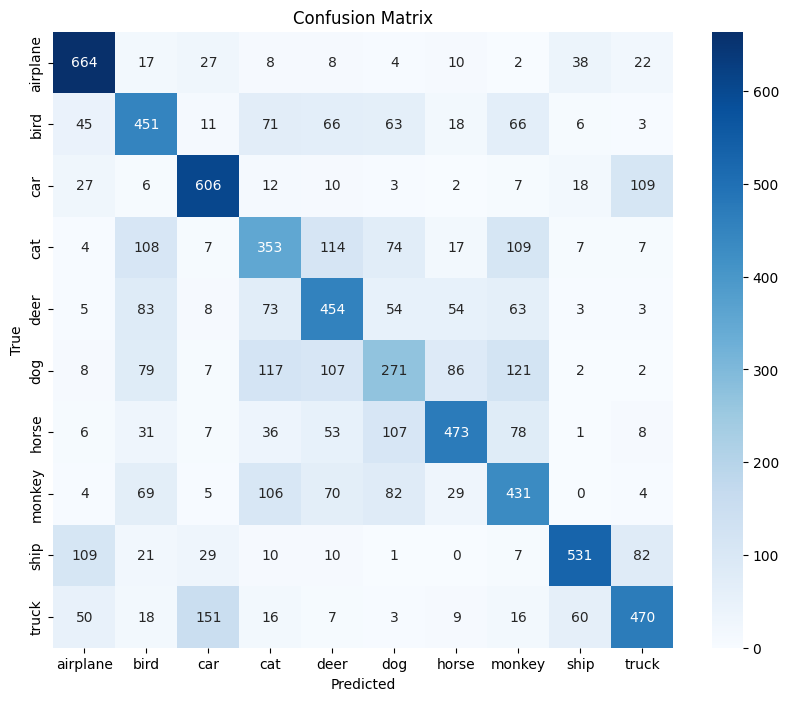

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
